In [8]:
import gzip
import numpy as np
from collections import defaultdict
from sklearn import linear_model
import csv
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import json
import statistics
import random
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from matplotlib.colors import ListedColormap
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [1]:
# loading in dataset

In [3]:
data = []
with open('endomondoHR_proper.json') as f:
    for l in f:
        data.append(eval(l))

In [5]:
endoData = data

In [6]:
sports = [d['sport'] for d in endoData]

In [9]:
sportsNum = defaultdict(int)
for d in endoData:
    sportsNum[d['sport']] += 1

# Part 1: Exploratory analysis of dataset

### Exploring dataset to determine what can be used as a predictive feature

#### To begin, data was filtered to only include activities with more than 100 entries in dataset

In [10]:
filterData = []
for d in endoData:
    sport = d['sport'] 
    if sportsNum[sport] < 100:
        continue
    else:
        filterData.append(d)

In [11]:
filtersportsNum = defaultdict(int)
for d in filterData:
    filtersportsNum[d['sport']] += 1

### Data structures were built in the below fashion, compiling statistics for both activity mean and max values and linking workout IDs to mean and max values

In [12]:
HR_sums = defaultdict(int)
HR_max = defaultdict(int) 
idAvgHR = {} 
idMaxHR = {} 
for d in filterData:
    avg = sum(d['heart_rate']) / len(d['heart_rate'])
    maxHR = max(d['heart_rate'])
    idAvgHR[d['id']] = avg
    HR_sums[d['sport']] += avg
    HR_max[d['sport']] += maxHR
    idMaxHR[d['id']] = maxHR

In [13]:
HR_avg = {}
HRmaxAvg = {}
for d in HR_sums:
    avg = HR_sums[d] / filtersportsNum[d]
    HRmaxAvg[d] = HR_max[d] / filtersportsNum[d]
    HR_avg[d] = avg
HR_avg #Average Heart Rate for each activity

{'bike': 133.4317747062495,
 'bike (transport)': 126.7027379141422,
 'run': 147.10291328922992,
 'mountain bike': 135.45045140831908,
 'orienteering': 147.30912802768174,
 'indoor cycling': 133.21582492753586,
 'skate': 120.70117343173445,
 'cross-country skiing': 137.60238783269963,
 'core stability training': 129.3156473214286,
 'walk': 102.55944918541508,
 'hiking': 110.85838818565402,
 'fitness walking': 116.52337671232883,
 'roller skiing': 129.87064705882358}

In [16]:
speed_max = defaultdict(int)
speed_avg = defaultdict(int)
idAvgSpeed = {}
idMaxSpeed = {} 
samples = defaultdict(int)
for d in filterData:
    if 'speed' not in d:
        continue
    speed_max[d['sport']] += max(d['speed'])
    speed_avg[d['sport']] += statistics.mean(d['speed'])
    idAvgSpeed[d['id']] = statistics.mean(d['speed'])
    idMaxSpeed[d['id']] = max(d['speed'])
    samples[d['sport']] += 1

In [17]:
avgMaxSpeed = defaultdict(int)
avgAvgSpeed = defaultdict(int)
for d in samples:
    speed = speed_max[d]/samples[d]
    avgMaxSpeed[d] = speed
    avgAvgSpeed[d] = speed_avg[d] / samples[d]
avgMaxSpeed #Average Maximum Speed reached for each activity

defaultdict(int,
            {'bike': 47.94665899491041,
             'bike (transport)': 40.67649933142317,
             'run': 18.510499184876863,
             'indoor cycling': 40.05016799999997,
             'mountain bike': 44.98322411067192,
             'orienteering': 16.18069090909091,
             'core stability training': 39.2514761904762,
             'walk': 14.667564705882347,
             'cross-country skiing': 29.952868965517236,
             'fitness walking': 20.344320000000003,
             'roller skiing': 25.428126315789473,
             'skate': 32.292300000000004,
             'hiking': 17.540100000000002})

In [25]:
len(idAvgSpeed)

31662

In [18]:
globalMaxSpeed = statistics.mean(avgMaxSpeed.values())
globalMaxSpeed 

29.832653592972193

In [27]:
avgAvgSpeed #Average speed for each activity

defaultdict(int,
            {'bike': 27.090390808120418,
             'bike (transport)': 23.408784377459437,
             'run': 11.520197007388134,
             'indoor cycling': 27.365575679999974,
             'mountain bike': 20.326191958893297,
             'orienteering': 10.734081381818182,
             'core stability training': 15.533825352380951,
             'walk': 6.376824070588237,
             'cross-country skiing': 14.339669213793103,
             'fitness walking': 7.9100088,
             'roller skiing': 15.421327578947368,
             'skate': 21.457228200000003,
             'hiking': 6.800796})

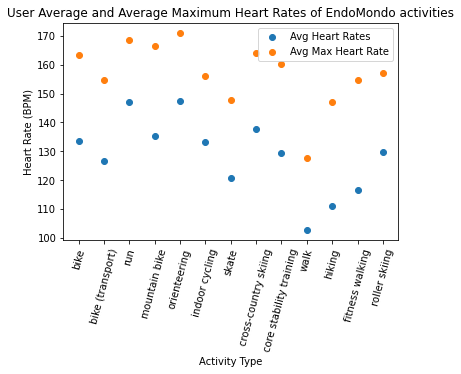

In [28]:
hlist = HR_avg.items()
slist = HRmaxAvg.items()
a,b = zip(*slist)
x,y = zip(*hlist)
plt.scatter(x,y, label = 'Avg Heart Rates')
plt.scatter(a,b, label = 'Avg Max Heart Rate')
plt.xticks(rotation=75)
plt.xlabel("Activity Type")
plt.ylabel("Heart Rate (BPM)")
plt.title("User Average and Average Maximum Heart Rates of EndoMondo activities")
plt.legend()

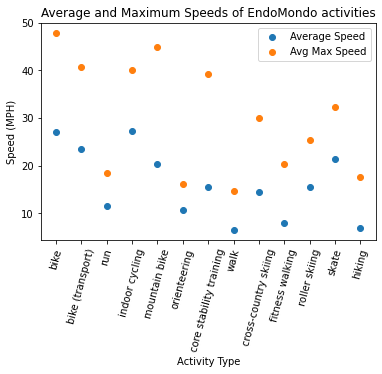

In [29]:
hlist = avgAvgSpeed.items()
slist = avgMaxSpeed.items()
a,b = zip(*slist)
x,y = zip(*hlist)
plt.scatter(x,y, label = 'Average Speed')
plt.scatter(a,b, label = 'Avg Max Speed')
plt.xticks(rotation=75)
plt.xlabel("Activity Type")
plt.ylabel("Speed (MPH)")
plt.title("Average and Maximum Speeds of EndoMondo activities")
plt.legend()

In [19]:
#sumAlt for computing change in altitude per sport
sumAlt = defaultdict(int) 
#altUser for storing altitude change for each workout
altUser = {} 
for d in filterData:
    change = max(d['altitude']) - min(d['altitude'])
    altUser[d['id']] = change
    sumAlt[d['sport']] += change

In [20]:
meanAlt = {} 
for m in sumAlt:
    meanAlt[m] = sumAlt[m] / filtersportsNum[m]
meanAlt #Mean Altitude change for each activity

{'bike': 94.75975529917216,
 'bike (transport)': 64.7576687433287,
 'run': 64.20693326504222,
 'mountain bike': 136.9838830116585,
 'orienteering': 51.351807381776254,
 'indoor cycling': 41.575650182028944,
 'skate': 40.69343687084869,
 'cross-country skiing': 134.513334311787,
 'core stability training': 72.0895888214286,
 'walk': 55.00664953840175,
 'hiking': 286.4424215189872,
 'fitness walking': 75.37105866438351,
 'roller skiing': 117.8817033613445}

Text(0.5, 1.0, 'Average Altitude Change of EndoMondo activities')

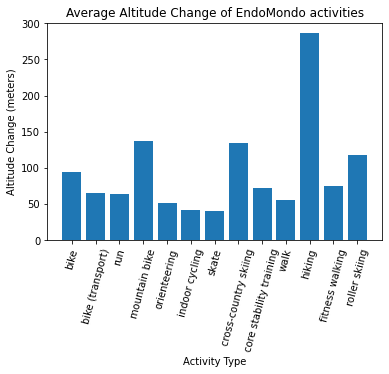

In [32]:
hlist = meanAlt.items()
x,y = zip(*hlist)
plt.bar(x,y, label = 'Average Altitude Change')
plt.xticks(rotation=75)
plt.xlabel("Activity Type")
plt.ylabel("Altitude Change (meters)")
plt.title("Average Altitude Change of EndoMondo activities")

In [21]:
gender = defaultdict(int) 
for d in filterData:
    gender[d['gender']] += 1
gender 

defaultdict(int, {'male': 156145, 'female': 9819, 'unknown': 1177})

Text(0.5, 1.0, 'Gender breakdown of EndoMondo Users')

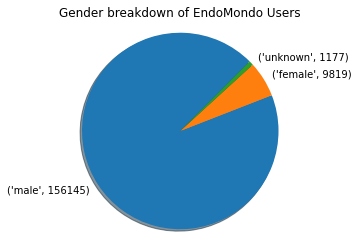

In [34]:
labels = gender.items()
sizes = [(gender['male']/len(gender)), (gender['female']/len(gender)), (gender['unknown']/len(gender)) ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=45)
ax1.axis('equal')
plt.title("Gender breakdown of EndoMondo Users")

In [35]:
## Baselines: Predict bike every time

In [36]:
women_stats = defaultdict(int)
men_stats = defaultdict(int)
for d in filterData:
    if d['gender'] == 'female':
        women_stats[d['sport']] += 1
    elif d['gender'] == 'male':
        men_stats[d['sport']] += 1

In [37]:
women_stats

defaultdict(int,
            {'bike (transport)': 235,
             'bike': 2921,
             'run': 5575,
             'orienteering': 44,
             'mountain bike': 277,
             'indoor cycling': 81,
             'walk': 263,
             'skate': 19,
             'core stability training': 43,
             'cross-country skiing': 167,
             'roller skiing': 5,
             'hiking': 40,
             'fitness walking': 149})

In [38]:
women_con = defaultdict(int) 
for i in women_stats:
    if women_stats[i] < 200:
        women_con['other'] += women_stats[i]
    else:
        women_con[i] = women_stats[i]
women_con

defaultdict(int,
            {'bike (transport)': 235,
             'bike': 2921,
             'run': 5575,
             'other': 548,
             'mountain bike': 277,
             'walk': 263})

In [39]:
wsize = sum(women_con.values())
wsize

9819

Text(0.5, 1.0, 'Activity breakdown of Female EndoMondo Users')

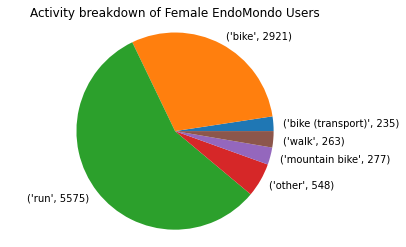

In [40]:
labels = women_con.items()
sizes = [ women_con['bike (transport)'], women_con['bike'] , women_con['run'], women_con['other'] , women_con['mountain bike'] , women_con['walk'] ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=0)
ax1.axis('equal')
plt.title("Activity breakdown of Female EndoMondo Users") 

In [41]:
men_stats

defaultdict(int,
            {'bike': 68386,
             'bike (transport)': 7521,
             'run': 64548,
             'mountain bike': 10362,
             'indoor cycling': 1633,
             'skate': 252,
             'cross-country skiing': 622,
             'core stability training': 400,
             'walk': 1026,
             'hiking': 197,
             'orienteering': 823,
             'fitness walking': 142,
             'roller skiing': 233})

In [42]:
men_con = defaultdict(int) 
for i in men_stats:
    if men_stats[i] < 2000:
        men_con['other'] += men_stats[i]
    else:
        men_con[i] = men_stats[i]
men_con

defaultdict(int,
            {'bike': 68386,
             'bike (transport)': 7521,
             'run': 64548,
             'mountain bike': 10362,
             'other': 5328})

Text(0.5, 1.0, 'Activity breakdown of Male EndoMondo Users')

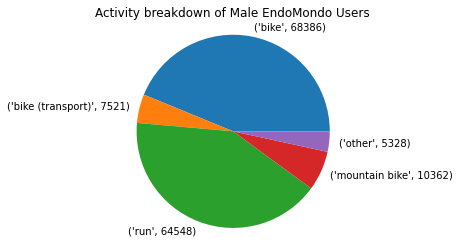

In [43]:
labels = men_con.items()
sizes = [men_con['bike'] , men_con['bike (transport)'], men_con['run'], men_con['mountain bike'] , men_con['other'] ]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=False, startangle=0)
ax1.axis('equal')
plt.title("Activity breakdown of Male EndoMondo Users") 

In [45]:
size = len(filterData)
size # number of workouts in filtered dataset

167141

In [46]:
condensed = defaultdict(int)
for i in filtersportsNum:
    if filtersportsNum[i] < 2000:
        condensed['other'] += filtersportsNum[i]
    else:
        condensed[i] = filtersportsNum[i]
condensed

defaultdict(int,
            {'bike': 71915,
             'bike (transport)': 7757,
             'run': 70591,
             'mountain bike': 10722,
             'other': 6156})

Text(0.5, 1.0, 'Activity breakdown of All EndoMondo Users')

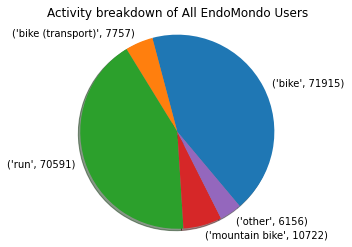

In [47]:
labels = condensed.items()
sizes = [(filtersportsNum['bike']/size), (filtersportsNum['bike (transport)']/size), (filtersportsNum['run']/size), (filtersportsNum['mountain bike']/size), (condensed['other']/size)]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, shadow=True, startangle=310)
ax1.axis('equal')
plt.title("Activity breakdown of All EndoMondo Users") 

In [22]:
long_sums = defaultdict(int)
lat_sums = defaultdict(int)
long_id = {} 
lat_id = {} 
for d in filterData:
    long = max(d['longitude']) - min(d['longitude'])
    lat = max(d['latitude']) - min(d['latitude'])
    long_id[d['id']] = long
    lat_id[d['id']] = lat
    long_sums[d['sport']] += long
    lat_sums[d['sport']] += lat

In [23]:
avgLong = defaultdict(int)
avgLat = defaultdict(int)
for i in filtersportsNum:
    avgLong[i] = long_sums[i] / filtersportsNum[i]
    avgLat[i] = lat_sums[i] / filtersportsNum[i]

In [50]:
avgLong #average longitude change for each activity

defaultdict(int,
            {'bike': 0.14308488895797997,
             'bike (transport)': 0.11808336941715437,
             'run': 0.03850127851431308,
             'mountain bike': 0.10015792674494045,
             'orienteering': 0.02888568856831222,
             'indoor cycling': 0.0070514591638117866,
             'skate': 0.04607312752707733,
             'cross-country skiing': 0.06446048522329155,
             'core stability training': 0.04343596294397522,
             'walk': 0.023578805805347155,
             'hiking': 0.039925016227022665,
             'fitness walking': 0.041056265437977885,
             'roller skiing': 0.07086336978218712})

In [51]:
avgLat #average latitude change for each activity

defaultdict(int,
            {'bike': 0.09524951296496922,
             'bike (transport)': 0.09048154494510502,
             'run': 0.023826905046391234,
             'mountain bike': 0.06303984829745889,
             'orienteering': 0.015740898421929318,
             'indoor cycling': 0.006009333302391453,
             'skate': 0.02630670390978264,
             'cross-country skiing': 0.03134833109639658,
             'core stability training': 0.021476740376835824,
             'walk': 0.014098816679649113,
             'hiking': 0.020744880480439907,
             'fitness walking': 0.018813085023127365,
             'roller skiing': 0.03903332097016901})

Text(0.5, 1.0, 'Max Latitude and Longitude Change for each Activity type')

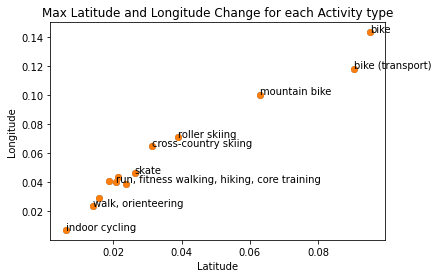

In [53]:
latlist = list(avgLat.values())
longlist = list(avgLong.values())
act = avgLat.keys()

plt.scatter(latlist, longlist) 
for i, txt in enumerate(act):
    if i == 4 or i == 11 or i == 8 or i == 2:
        continue
    elif i == 10:
        plt.annotate("run, fitness walking, hiking, core training", (latlist[i], longlist[i]))
    elif i == 9:
        plt.annotate("walk, orienteering", (latlist[i], longlist[i]))
    else:
        plt.annotate(txt, (latlist[i], longlist[i]))

plt.scatter(latlist,longlist, label = 'Average Altitude Change')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Max Latitude and Longitude Change for each Activity type")

# Part 2: Building and trying out candidate models

### Data was split into training and test sets, and various feature/model combinations were tested

In [54]:
#Error rate function for evaluating model accuracy
def BER(predictions, y):
    if len(predictions) != len(y):
        print("Error: Predictions and values lengths are not equal")
        return 1; 
    total = len(y)
    values = 0
    for p,l in zip(predictions, y):
        if p == l:
            values += 1
    rate = (values/total) * 100
    return str(rate) + "% correct"

In [55]:
shuffleData1 = filterData

In [56]:
random.seed(2)
random.shuffle(shuffleData1) #shuffling data

In [57]:
n = int(len(shuffleData1) * 3 / 4)

In [58]:
train1 = shuffleData1[:n]
len(train1) #training split

125355

In [59]:
trainDict = defaultdict(int)
for d in train1:
    trainDict[d['sport']] += 1
trainDict

defaultdict(int,
            {'run': 52924,
             'bike': 53952,
             'mountain bike': 7999,
             'indoor cycling': 1285,
             'bike (transport)': 5864,
             'walk': 990,
             'hiking': 176,
             'core stability training': 325,
             'roller skiing': 181,
             'orienteering': 657,
             'cross-country skiing': 597,
             'fitness walking': 207,
             'skate': 198})

In [60]:
test1 = shuffleData1[n:]
len(test1) #testing split

41786

In [ ]:
testDict = defaultdict(int)
for d in test1:
    testDict[d['sport']] += 1
testDict

In [58]:
test1actual = [d['sport'] for d in test1]

In [59]:
guessbike = ['bike' for d in test1]

## The "Predicting bike every time" model

In [60]:
BER(guessbike, test1actual)

'42.988082132771744% correct'

## Using max speed as a feature in logistic regression

In [61]:
mod1 = linear_model.LogisticRegression(multi_class='multinomial')

In [62]:
mod1_1 = linear_model.LogisticRegression(multi_class='multinomial')

In [63]:
def basicfeat(data):
    feat = [1] 
    return feat

In [64]:
def maxSpeedfeat(data):
    feat = [1] 
    if data['id'] not in idMaxSpeed.keys():
        feat.append(globalMaxSpeed)
    else:
        feat.append(idMaxSpeed[data['id']])
    return feat

In [65]:
len(idMaxSpeed)

31662

In [66]:
x_train1 = [maxSpeedfeat(d) for d in train1]

In [67]:
y_train1 = [d['sport'] for d in train1]

In [68]:
mod1.fit(x_train1, y_train1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [69]:
x_speedtest = [maxSpeedfeat(d) for d in test1] 

In [70]:
speedPreds1 = mod1.predict(x_speedtest)

In [71]:
BER(speedPreds1, test1actual)

'51.48375053845786% correct'

In [72]:
# function to print a summary of what the model predicted
def predictionBreakdown(predictions):
    predictionDict = defaultdict(int)
    for d in predictions:
        predictionDict[d] += 1 
    return predictionDict

In [73]:
predictionBreakdown(speedPreds1)

defaultdict(int, {'run': 36999, 'bike': 4787})

In [74]:
##this predictor is slightly better than the "guess only bike" baseline,
##however due to the sparcity of speed data barely breaks 50% accuracy

## Using average Heart Rate as a feature in a logistic regressor

In [75]:
def avgHRfeat(data):
    feat = [1] 
    feat.append(idAvgHR[data['id']])
    return feat

In [76]:
mod2 = linear_model.LogisticRegression(multi_class='multinomial')

In [77]:
x_train2 = [avgHRfeat(d) for d in train1]
y_train2 = [d['sport'] for d in train1]
mod2.fit(x_train2,y_train2)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [78]:
x_avgHRtest = [avgHRfeat(d) for d in test1]
avgHRpreds1 = mod2.predict(x_avgHRtest)

In [79]:
BER(avgHRpreds1, test1actual)

'58.0146460537022% correct'

In [80]:
## improvement to 58% accuracy

In [81]:
predictionBreakdown(avgHRpreds1) #test predictions

defaultdict(int, {'bike': 21219, 'run': 20566, 'hiking': 1})

In [82]:
predictionBreakdown(test1actual) #real test data

defaultdict(int,
            {'bike': 17963,
             'run': 17667,
             'bike (transport)': 1893,
             'mountain bike': 2723,
             'fitness walking': 85,
             'hiking': 61,
             'cross-country skiing': 192,
             'orienteering': 210,
             'walk': 299,
             'core stability training': 123,
             'indoor cycling': 440,
             'skate': 73,
             'roller skiing': 57})

## Latitude and longitude logistic regression model

In [84]:
def latlongfeat(data):
    feat = [1]
    feat.append(long_id[data['id']])
    feat.append(lat_id[data['id']])
    return feat

In [85]:
x_train3 = [latlongfeat(d) for d in train1]
y_train3 = [d['sport'] for d in train1]


In [86]:
mod3 = linear_model.LogisticRegression(multi_class='multinomial', max_iter=400)
mod3.fit(x_train3,y_train3)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, multi_class='multinomial')

In [87]:
x_latlong = [latlongfeat(d) for d in test1]
latlongpreds1 = mod3.predict(x_latlong)

In [88]:
print(BER(latlongpreds1, test1actual))
predictionBreakdown(latlongpreds1)

73.19197817450821% correct


defaultdict(int, {'bike': 19343, 'run': 22443})

In [89]:
## accuracy improves to 73%, however the classifier is still only predicting
## either run or bike, the two most common activities

In [24]:
##alternate training/test split 
shuffleData2 = filterData

In [25]:
random.seed(5)
random.shuffle(shuffleData2)

In [26]:
l = len(shuffleData2)
l

167141

In [27]:
m = int(l *3/4)

In [28]:
train2 = shuffleData2[:l//2]
test2 = shuffleData2[l//2:m]
test3 = shuffleData2[m:]

### Similar model, but with different training/test splits and more iterations to ensure convergence

In [95]:
x_train4 = [latlongfeat(d) for d in train2]
y_train4 = [d['sport'] for d in train2]
x_test4 = [latlongfeat(d) for d in test2]
y_test4 = [d['sport'] for d in test2]

In [96]:
mod4 = linear_model.LogisticRegression(multi_class='multinomial', max_iter=600)
mod4.fit(x_train4,y_train4)

LogisticRegression(max_iter=600, multi_class='multinomial')

In [97]:
preds4 = mod4.predict(x_test4)

In [98]:
print(BER(preds4, y_test4))
predictionBreakdown(preds4)

72.76295321287543% correct


defaultdict(int, {'bike': 19368, 'run': 22417})

In [99]:
trainpred4 = mod4.predict(x_train4)
print(BER(trainpred4, y_train4))
predictionBreakdown(trainpred4)

73.17338757927486% correct


defaultdict(int, {'run': 44914, 'bike': 38656})

In [100]:
predictionBreakdown(y_train4)

defaultdict(int,
            {'bike': 35903,
             'run': 35347,
             'orienteering': 464,
             'mountain bike': 5379,
             'bike (transport)': 3877,
             'hiking': 117,
             'indoor cycling': 826,
             'walk': 655,
             'cross-country skiing': 374,
             'core stability training': 211,
             'skate': 143,
             'roller skiing': 128,
             'fitness walking': 146})

In [101]:
x_test3 = [latlongfeat(d) for d in test3]
y_test3 = [d['sport'] for d in test3]
preds3 = mod4.predict(x_test3)

In [102]:
print(BER(preds3, y_test3))
predictionBreakdown(preds3)

73.44804479969368% correct


defaultdict(int, {'bike': 19363, 'run': 22423})

## Latitude, Longitude and Heart Rate data, with scaling, fitted to a logistic regressor

In [105]:
def latlongHRfeat(data):
    feat = [1]
    feat.append(long_id[data['id']])
    feat.append(lat_id[data['id']])
    feat.append(idAvgHR[data['id']])
    return feat

In [106]:
x_train5 = [latlongHRfeat(d) for d in train2]
y_train5 = [d['sport'] for d in train2]
x_test5 = [latlongHRfeat(d) for d in test2]
y_test5 = [d['sport'] for d in test2]

In [107]:
scaler = StandardScaler()
x_train5 = scaler.fit_transform(x_train5)
x_test5 = scaler.transform(x_test5)

In [108]:
mod5 = linear_model.LogisticRegression(multi_class='multinomial', max_iter=600)
mod5.fit(x_train5,y_train5)
preds5_2 = mod5.predict(x_test5)

In [109]:
print(BER(preds5_2, y_test5))
predictionBreakdown(preds5_2)

74.23238004068445% correct


defaultdict(int,
            {'run': 21453, 'bike': 20177, 'walk': 141, 'bike (transport)': 14})

In [110]:
predictionBreakdown(y_test5)

defaultdict(int,
            {'bike': 17905,
             'bike (transport)': 2005,
             'run': 17635,
             'mountain bike': 2722,
             'indoor cycling': 454,
             'skate': 71,
             'core stability training': 99,
             'cross-country skiing': 186,
             'walk': 338,
             'hiking': 61,
             'fitness walking': 71,
             'orienteering': 194,
             'roller skiing': 44})

## Random Forest Classifier for Latitude, Longitude and HR data 

In [111]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42, class_weight='balanced')
classifier.fit(x_train5, y_train5)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=10, random_state=42)

In [112]:
preds6 = classifier.predict(x_test5)

In [113]:
print(BER(preds6, y_test5))
predictionBreakdown(preds6)

78.99485461289937% correct


defaultdict(int,
            {'run': 18976,
             'bike': 19702,
             'bike (transport)': 1518,
             'mountain bike': 875,
             'indoor cycling': 337,
             'core stability training': 48,
             'walk': 245,
             'cross-country skiing': 20,
             'hiking': 12,
             'fitness walking': 19,
             'orienteering': 14,
             'roller skiing': 4,
             'skate': 15})

#### Random Forest Classifier both boosts classification accuracy and includes infrequent activities in prediction

## Random Forest Classifier for Latitude, Longitude, Heart Rate, and Altitude data 

In [114]:
def latlongHRaltfeat(data):
    feat = [1]
    feat.append(long_id[data['id']])
    feat.append(lat_id[data['id']])
    feat.append(idAvgHR[data['id']])
    feat.append(altUser[data['id']])
    return feat

In [115]:
x_train6 = [latlongHRaltfeat(d) for d in train2]
y_train6 = [d['sport'] for d in train2]
x_valid6 = [latlongHRaltfeat(d) for d in test2]
y_valid6 = [d['sport'] for d in test2]
x_test6 = [latlongHRaltfeat(d) for d in test3]
y_test6 = [d['sport'] for d in test3]

In [116]:
scaler = StandardScaler()
x_train6 = scaler.fit_transform(x_train6)
x_valid6 = scaler.transform(x_valid6)
x_test6 = scaler.transform(x_test6)

In [117]:
clf2 = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42, class_weight='balanced')
clf2.fit(x_train6, y_train6)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=20, random_state=42)

In [118]:
preds6 = clf2.predict(x_valid6)
print(BER(preds6, y_valid6))
predictionBreakdown(preds6) #predictions

80.78975708986479% correct


defaultdict(int,
            {'bike': 19467,
             'bike (transport)': 1513,
             'run': 19325,
             'mountain bike': 805,
             'indoor cycling': 357,
             'core stability training': 25,
             'hiking': 19,
             'walk': 240,
             'cross-country skiing': 10,
             'skate': 8,
             'orienteering': 4,
             'fitness walking': 9,
             'roller skiing': 3})

In [119]:
predictionBreakdown(y_valid6) #actual data

defaultdict(int,
            {'bike': 17905,
             'bike (transport)': 2005,
             'run': 17635,
             'mountain bike': 2722,
             'indoor cycling': 454,
             'skate': 71,
             'core stability training': 99,
             'cross-country skiing': 186,
             'walk': 338,
             'hiking': 61,
             'fitness walking': 71,
             'orienteering': 194,
             'roller skiing': 44})

In [121]:
testpred6 = clf2.predict(x_test6)
print(BER(testpred6, y_test6))
predictionBreakdown(testpred6)

81.09414636481118% correct


defaultdict(int,
            {'bike': 19568,
             'run': 19243,
             'indoor cycling': 350,
             'mountain bike': 907,
             'bike (transport)': 1390,
             'walk': 242,
             'cross-country skiing': 10,
             'roller skiing': 11,
             'skate': 9,
             'core stability training': 26,
             'hiking': 16,
             'fitness walking': 14})

## Extra Trees Classifier with Latitude, Longitude, Heart Rate, and Altitude features

In [122]:
clf3 = ExtraTreesClassifier(criterion = 'entropy', random_state = 69, class_weight='balanced', oob_score=True, bootstrap=True)
clf3.fit(x_train6, y_train6)
preds7 = clf3.predict(x_valid6)
print(BER(preds7, y_valid6))
predictionBreakdown(preds7)

81.11523273902118% correct


defaultdict(int,
            {'bike': 19454,
             'bike (transport)': 1445,
             'run': 19742,
             'mountain bike': 535,
             'indoor cycling': 334,
             'core stability training': 15,
             'walk': 221,
             'skate': 11,
             'fitness walking': 7,
             'hiking': 15,
             'roller skiing': 2,
             'cross-country skiing': 4})

In [123]:
clf3.oob_score_

0.8120138805791552

In [124]:
preds8 = clf3.predict(x_test6)
print(BER(preds8, y_test6))
predictionBreakdown(preds8)

81.52969894222946% correct


defaultdict(int,
            {'bike': 19656,
             'run': 19647,
             'indoor cycling': 334,
             'mountain bike': 550,
             'bike (transport)': 1319,
             'walk': 235,
             'roller skiing': 10,
             'core stability training': 10,
             'skate': 5,
             'fitness walking': 11,
             'hiking': 6,
             'cross-country skiing': 3})

In [125]:
testpred8 = clf2.predict(x_test6)
print(BER(testpred8, y_test6))
predictionBreakdown(testpred8)

81.09414636481118% correct


defaultdict(int,
            {'bike': 19568,
             'run': 19243,
             'indoor cycling': 350,
             'mountain bike': 907,
             'bike (transport)': 1390,
             'walk': 242,
             'cross-country skiing': 10,
             'roller skiing': 11,
             'skate': 9,
             'core stability training': 26,
             'hiking': 16,
             'fitness walking': 14})

In [126]:
predictionBreakdown(y_test6)

defaultdict(int,
            {'bike': 18107,
             'run': 17609,
             'mountain bike': 2621,
             'bike (transport)': 1875,
             'fitness walking': 75,
             'walk': 296,
             'indoor cycling': 445,
             'core stability training': 138,
             'cross-country skiing': 229,
             'orienteering': 209,
             'roller skiing': 66,
             'hiking': 59,
             'skate': 57})

## Support Vector Machines Classifier with Latitude, Longitude, Heart Rate, and Altitude features

In [127]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(x_train6, y_train6)

In [128]:
rbf_pred = rbf.predict(x_test6)

In [129]:
rbf_accuracy = accuracy_score(y_test6, rbf_pred)
rbf_f1 = f1_score(y_test6, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  75.80
F1 (RBF Kernel):  70.71


## Extra Trees Classifier with Latitude, Longitude, Heart Rate, Altitude and Gender features  

In [30]:
#generating feature vectors with latitude, longitude, heart rate, altitude, and gender data
def latlongHRaltgenderfeat(data):
    feat = [1]
    feat.append(long_id[data['id']])
    feat.append(lat_id[data['id']])
    feat.append(idAvgHR[data['id']])
    feat.append(altUser[data['id']])
    if data['gender'] == 'male':
        feat.append(0)
    elif data['gender'] == 'female':
        feat.append(1)
    else:
        feat.append(2)
    return feat

In [31]:
x_train7 = [latlongHRaltgenderfeat(d) for d in train2]
y_train7 = [d['sport'] for d in train2]
x_valid7 = [latlongHRaltgenderfeat(d) for d in test2]
y_valid7 = [d['sport'] for d in test2]
x_test7 = [latlongHRaltgenderfeat(d) for d in test3]
y_test7 = [d['sport'] for d in test3]

In [68]:
scaler = StandardScaler()
x_train7 = scaler.fit_transform(x_train7)
x_valid7 = scaler.transform(x_valid7)
x_test7= scaler.transform(x_test7)

In [134]:
clf4 = ExtraTreesClassifier(criterion = 'entropy', random_state = 69, class_weight='balanced', oob_score=True, bootstrap=True)
clf4.fit(x_train7, y_train7)
preds8 = clf4.predict(x_valid7)
print(BER(preds8, y_valid7))
predictionBreakdown(preds8)

81.46942682780902% correct


defaultdict(int,
            {'bike': 19351,
             'bike (transport)': 1452,
             'run': 19759,
             'mountain bike': 564,
             'indoor cycling': 315,
             'core stability training': 21,
             'walk': 265,
             'cross-country skiing': 13,
             'skate': 10,
             'fitness walking': 20,
             'hiking': 13,
             'roller skiing': 2})

In [136]:
predictionBreakdown(y_valid7)

defaultdict(int,
            {'bike': 17905,
             'bike (transport)': 2005,
             'run': 17635,
             'mountain bike': 2722,
             'indoor cycling': 454,
             'skate': 71,
             'core stability training': 99,
             'cross-country skiing': 186,
             'walk': 338,
             'hiking': 61,
             'fitness walking': 71,
             'orienteering': 194,
             'roller skiing': 44})

In [135]:
preds9 = clf4.predict(x_test7)
print(BER(preds9, y_test7))
predictionBreakdown(preds9)

81.87431197051644% correct


defaultdict(int,
            {'bike': 19568,
             'run': 19611,
             'indoor cycling': 322,
             'mountain bike': 592,
             'bike (transport)': 1350,
             'walk': 262,
             'cross-country skiing': 16,
             'roller skiing': 13,
             'core stability training': 16,
             'skate': 4,
             'hiking': 11,
             'fitness walking': 21})

## AdaBoost Classifiers with Latitude, Longitude, Heart Rate, Altitude and Gender features  

In [158]:
ada1 = AdaBoostClassifier(n_estimators=100).fit(x_train7, y_train7)
adapreds1 = ada1.predict(x_valid7)
print(BER(adapreds1, y_valid7))
predictionBreakdown(adapreds1)

67.96936699772645% correct


defaultdict(int,
            {'run': 18628,
             'bike': 18300,
             'skate': 927,
             'bike (transport)': 856,
             'core stability training': 435,
             'fitness walking': 334,
             'walk': 238,
             'indoor cycling': 951,
             'hiking': 991,
             'mountain bike': 108,
             'orienteering': 8,
             'cross-country skiing': 9})

In [163]:
ada1 = AdaBoostClassifier(n_estimators=40).fit(x_train7, y_train7)
adapreds1 = ada1.predict(x_valid7)
print(BER(adapreds1, y_valid7))
predictionBreakdown(adapreds1)

72.6911571137968% correct


defaultdict(int,
            {'run': 20019,
             'bike': 19919,
             'skate': 608,
             'walk': 445,
             'indoor cycling': 555,
             'fitness walking': 99,
             'hiking': 31,
             'mountain bike': 86,
             'bike (transport)': 16,
             'cross-country skiing': 7})

In [164]:
adapreds2 = ada1.predict(x_test7)
print(BER(adapreds2, y_test7))
predictionBreakdown(adapreds2)

73.19437132053798% correct


defaultdict(int,
            {'bike': 20025,
             'run': 19907,
             'indoor cycling': 573,
             'skate': 567,
             'walk': 482,
             'fitness walking': 92,
             'mountain bike': 95,
             'hiking': 24,
             'bike (transport)': 10,
             'cross-country skiing': 11})

In [166]:
ada2 = AdaBoostClassifier(algorithm='SAMME').fit(x_train7, y_train7)
ada2preds = ada2.predict(x_valid7)
print(BER(ada2preds, y_valid7))
predictionBreakdown(ada2preds)

72.55713772885007% correct


defaultdict(int, {'bike': 20378, 'run': 21296, 'mountain bike': 111})

# Part 3: Optimizing Chosen Model

### The Extra Trees Classifier with Latitude, Longitude, Heart Rate, Altitude and Gender features was generally the most accurate, so now we will tweak hyperparameters to optimize accuracy  

In [35]:
def evaluate_model(X, y, model): # perform 5-fold validation of the data
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) 
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [169]:
clf5 = ExtraTreesClassifier(criterion = 'entropy', class_weight='balanced')
scores = evaluate_model(x_train7, y_train7, clf5)

In [170]:
scores # accuracy scores (out of 1) for various splits of the dataset

array([0.81608233, 0.81584301, 0.81596267, 0.81733876, 0.81488572,
       0.81895417, 0.81506521, 0.81811655, 0.8166208 , 0.8166208 ,
       0.81680029, 0.81237286, 0.81871485, 0.82033026, 0.81626182])

In [171]:
clf6 = ExtraTreesClassifier(criterion = 'entropy', class_weight='balanced', n_estimators=500)
scores2 = evaluate_model(x_train7, y_train7, clf6)
scores2

array([0.81656097, 0.81769774, 0.81769774, 0.81703961, 0.8172191 ,
       0.81668063, 0.81614216, 0.82033026, 0.81727893, 0.81715927,
       0.81703961, 0.81446691, 0.82074907, 0.82027043, 0.81925332])

In [172]:
clf7 = ExtraTreesClassifier(criterion = 'gini', class_weight='balanced')
scores3 = evaluate_model(x_train7, y_train7, clf7)
scores3

array([0.81494555, 0.81787723, 0.81829604, 0.81733876, 0.81817638,
       0.81530454, 0.81590284, 0.81739859, 0.819014  , 0.81530454,
       0.81703961, 0.81536437, 0.8178174 , 0.81823621, 0.81793706])

In [173]:
clf8 =  RandomForestClassifier( criterion = 'entropy', random_state = 42, class_weight='balanced')
scores4 = evaluate_model(x_train7, y_train7, clf8)
scores4

array([0.81338997, 0.81656097, 0.81560369, 0.81608233, 0.81691995,
       0.81410793, 0.8128515 , 0.81895417, 0.81703961, 0.81548403,
       0.81338997, 0.81440708, 0.81691995, 0.82068924, 0.81638148])

In [32]:
def get_models(): # test models with various numbers of trees for maximum accuracy
    models = dict()
    n_trees = [10, 50, 100, 250]
    for n in n_trees:
        models[str(n)] = ExtraTreesClassifier(n_estimators=n, criterion='entropy', class_weight='balanced')
    return models

In [33]:
models = get_models()

In [36]:
results, names = list(), list() 
for name, model in models.items():
    scores = evaluate_model(x_train7, y_train7, model) 
    results.append(scores)
    names.append(name)

    print('>%s %.3f (%.3f)' % (name, statistics.mean(scores), np.std(scores)))

>10 0.803 (0.003)
>50 0.815 (0.002)
>100 0.817 (0.002)
>250 0.818 (0.002)


Text(0.5, 1.0, 'Extra Trees Classifier Accuracy')

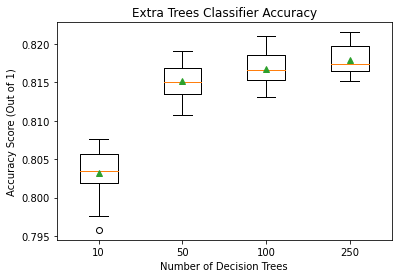

In [37]:
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel("Number of Decision Trees")
plt.ylabel("Accuracy Score (Out of 1)")
plt.title("Extra Trees Classifier Accuracy")

In [91]:
def features_model(): #test number of features per split point in decision tree
    models = dict()
    for i in range(1, 7):
        models[str(i)] = ExtraTreesClassifier(max_features=i,criterion='entropy', class_weight='balanced')
    return models

In [92]:
feature_models = features_model()

In [93]:
results, names = list(), list()
for name, model in feature_models.items():
    scores = evaluate_model(x_train7, y_train7, model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, statistics.mean(scores), np.std(scores)))

>1 0.815 (0.002)
>2 0.816 (0.002)
>3 0.818 (0.002)
>4 0.818 (0.002)
>5 0.818 (0.001)
>6 0.818 (0.001)


Text(0.5, 1.0, 'Extra Trees Classifier Accuracy')

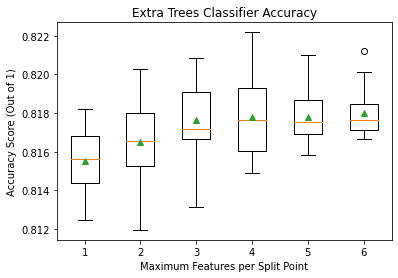

In [95]:
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel("Maximum Features per Split Point")
plt.ylabel("Accuracy Score (Out of 1)")
plt.title("Extra Trees Classifier Accuracy")

In [118]:
def get_modelsSplit(): #test the number of samples per split from 2 to 25
    models = dict()
    for i in range(2, 25):
        models[str(i)] = ExtraTreesClassifier(min_samples_split=i)
    return models

In [119]:
models2 = get_modelsSplit()

In [120]:
def evaluate_modelSplit(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [122]:
results, names = list(), list()
for name, model in models2.items():
    scores = evaluate_modelSplit(model, x_train7, y_train7)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, statistics.mean(scores), np.std(scores)))

>2 0.819 (0.003)
>3 0.819 (0.003)
>4 0.818 (0.004)
>5 0.816 (0.004)
>6 0.815 (0.003)
>7 0.815 (0.004)
>8 0.813 (0.004)
>9 0.812 (0.003)
>10 0.812 (0.004)
>11 0.810 (0.004)
>12 0.810 (0.004)
>13 0.809 (0.004)
>14 0.808 (0.003)
>15 0.807 (0.003)
>16 0.806 (0.004)
>17 0.806 (0.004)
>18 0.805 (0.004)
>19 0.805 (0.004)
>20 0.805 (0.003)
>21 0.804 (0.004)
>22 0.803 (0.004)
>23 0.803 (0.004)
>24 0.803 (0.004)


Text(0.5, 1.0, 'Extra Trees Classifier Accuracy')

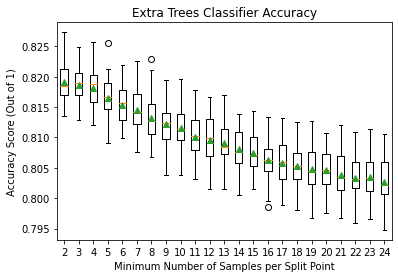

In [125]:
plt.boxplot(results, labels=names, showmeans=True)
plt.xlabel("Minimum Number of Samples per Split Point")
plt.ylabel("Accuracy Score (Out of 1)")
plt.title("Extra Trees Classifier Accuracy")

In [130]:
clf9 = ExtraTreesClassifier(criterion = 'entropy', random_state = 42, class_weight='balanced',min_samples_split=2, max_features=6, n_estimators=200 )
scores5 = evaluate_model(x_train7, y_train7, clf9)
scores5

array([0.81506521, 0.81955247, 0.81949264, 0.81829604, 0.81955247,
       0.82027043, 0.81787723, 0.81991145, 0.81817638, 0.81739859,
       0.81757808, 0.81584301, 0.81913366, 0.82260381, 0.81925332])

In [132]:
statistics.mean(scores5) #mean accuracy of all folds

0.8186669857604404

In [137]:
df = pd.DataFrame(scores5, columns=['Accuracy Scores'])
df.pivot #Accuracy Scores

<bound method DataFrame.pivot of     Accuracy Scores
0          0.815065
1          0.819552
2          0.819493
3          0.818296
4          0.819552
5          0.820270
6          0.817877
7          0.819911
8          0.818176
9          0.817399
10         0.817578
11         0.815843
12         0.819134
13         0.822604
14         0.819253>

In [149]:
scores5 = scores5.reshape(3,5)
scores5

array([[0.81506521, 0.81955247, 0.81949264, 0.81829604, 0.81955247],
       [0.82027043, 0.81787723, 0.81991145, 0.81817638, 0.81739859],
       [0.81757808, 0.81584301, 0.81913366, 0.82260381, 0.81925332]])

In [154]:
df = pd.DataFrame(scores5, columns = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5'])
df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
0,0.815065,0.819552,0.819493,0.818296,0.819552
1,0.820270,0.817877,0.819911,0.818176,0.817399
2,0.817578,0.815843,0.819134,0.822604,0.819253


In [146]:
df.pivot_table

<bound method DataFrame.pivot_table of     Accuracy Scores
0          0.815065
1          0.819552
2          0.819493
3          0.818296
4          0.819552
5          0.820270
6          0.817877
7          0.819911
8          0.818176
9          0.817399
10         0.817578
11         0.815843
12         0.819134
13         0.822604
14         0.819253>